# d18op climatology, pos-neg IPO, pos-neg ENSO composites for 1880 -- 1999.
 
Figure 3. SASM (DJF) δ¹⁸Oₚ climatology and its response to Pacific Ocean modes. δ¹⁸Oₚ data are from the iCAM5 model (shading), terrestrial proxy records (circles), and IAEA station observations (triangles). a) DJF precipitation-weighted average of δ¹⁸Oₚ (1880 – 1999 CE). Composites of positive – negative phase years for b) IPO and c) ENSO. Reference period for iCAM5 and proxy data cover the full study period of 1880 – 1999 CE and IAEA data are available from 1965 – 1986 CE. Statistical significance at p<0.05 is indicated with a black cross for proxy records and IAEA stations and with black stippling for model simulations. Pumacocha, P00-H1 and CR1 records are shifted slightly for visibility.  

# Preamble

In [1]:
import os.path
import numpy as np
import pandas as pd
import xarray as xr   # use xarray to open data files instead of netCDF4.  It is faster, and easier. And, it keeps my metadata!
import netCDF4 as ncd
from netCDF4 import Dataset
import scipy
from scipy import stats
from scipy.stats import linregress
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import dask.array as da
from shapely.geometry.polygon import LinearRing

import proplot as pplt
import cartopy.feature as cf
import matplotlib.colors as mcols
import matplotlib.patches as patches
from matplotlib.lines import Line2D   

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# suppress annoying warnings in plotting
import warnings
from shapely.errors import ShapelyDeprecationWarning

# ---------------------------- Plotting specs
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# ---------------------------- Functions

def bounds(scalar_fields):
    """
    Get the bounds of a set of scalar_fields
    :param scalar_fields : the scalar field set
    :return: a set of normalized vector field components
    """
    max_bound = -np.inf
    min_bound = np.inf

    for scalar_field in scalar_fields:
        max_lim = np.max(scalar_field)
        min_lim = np.min(scalar_field)
        if max_lim > max_bound:
            max_bound = max_lim
        if min_lim < min_bound:
            min_bound = min_lim

    return np.around(min_bound,2), np.around(max_bound, 2)

def non_time_coords(ds):
    return [v for v in ds.data_vars
            if 'time' not in ds[v].dims]

def drop_non_essential_vars_pop(ds):
    return ds.drop(non_time_coords(ds))  

def drop_all_coords(ds):
    return ds.reset_coords(drop=True)

def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]
# xr.open_mfdataset('*.nc', combine='by_coords', preprocess=drop_all_coords)

def zscr(self):
    return ((self - np.mean(self))/np.std(self))

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - (fit - fit.mean())

# Load data:
- icam5 d18op
- proxy
- gnip data

In [2]:
path = "/network/rit/home/ro553136/orrison/data/CESM/iCAM5/cntl/atm/f09/"

fh_d18 = xr.open_dataset(path+'f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.d18o_pwt_1850_2013.nc', decode_times=True).sel(lat=slice(-50,10),lon=slice(140,350))

# model data, [30:-14]: 1880 -- 1999
d18_djf = fh_d18.d18o_pwt[30:-14] 
icam_yrs = fh_d18.time[30:-14]  
lat = d18_djf.lat
lon = d18_djf.lon
nlat = len(lat)
nlon = len(lon)

# Processing proxy data:

In [3]:
# Run script to generate nice data data frames
%run /network/rit/home/ro553136/orrison/Scripts/processing/proxy_recs_fileprocessing_ipo_enso.ipynb

# load proxy data
    # Make dictionary to store proxy information.
recs_ipo = ['P00H1', 'JAR4', 'CR1', 'SBE3', 'DV2+TR5+LD12', 'PIM4',
        'Quelccaya', 'Pumacocha','UTU','Cuy','Bol']
lat_pts_ipo = [-11.27, -21.08, -24.58, -13.81, -12.36,  -11.4,  -24.66, 
           -13.93, -10.7, -21.7, -0.45, -11.0]#
lon_pts_ipo = [284.21, 304.42, 311.42, 313.65, 318.43, 299.62, 310.46, 
           289.17, 283.94, 293.23, 281.96, 293.08]
    # interpolate huagapo to a lower position
# lat_pts_nn_p00 = (geo_loc(lat_pts[0],lat) - (lat[1]-lat[0])).values
# lat_pts[0] = lat_pts_nn_p00
rec_dict_enso = {'modpts': recs_ipo,'lat': lat_pts_ipo, 'lon': lon_pts_ipo}

recs_enso = ['Quelccaya', 'Pumacocha','UTU','Cuy','Bol']
lat_pts_enso = [ -24.66,  -13.93, -10.70, -21.7, -0.45, -11.0]
lon_pts_enso = [310.46, 289.17, 283.94, 293.23, 281.96, 293.08]
rec_dict_enso = {'modpts': recs_enso,'lat': lat_pts_enso, 'lon': lon_pts_enso}
 # --------------------------
 # Load dendro records

    # load UTU data onto the mceof pd DF
pth_den = "/network/rit/home/ro553136/orrison/data/proxy/dendro/iso_o/"
f_den = open(pth_den + "utu18O_1700-2013.robmean.csv")
utu = pd.read_csv(f_den, index_col=0)
utu_dat = utu['d18Outu'].iloc[180:-15]
utu_pd = pd.Series(utu_dat, index=utu.index[180:-15].values)
utu_pd.loc[1996] = 33.93

   # load Baker data: Ecuador and Bolivia
f_bak = "Baker_2022_supplemental_data.xlsx"
df_bak = pd.read_excel(open(pth_den + f_bak, 'rb'))
bak_yrs = df_bak.iloc[20:140, 0][::-1]
cuy_dat = df_bak.iloc[20:140, 1][::-1].astype(float)
cuy_pd = pd.Series(cuy_dat.values, index=bak_yrs.values)    
bol_dat = df_bak.iloc[20:140, 2][::-1].astype(float)
bol_pd = pd.Series(bol_dat.values, index=bak_yrs.values)    

# append dataframe with data values. All during current growing season. 
abs_prox_hist = abs_prox_hist.assign(UTU=utu_pd)
abs_prox_hist = abs_prox_hist.assign(Cuy=cuy_pd)
abs_prox_hist = abs_prox_hist.assign(Bol=bol_pd)

abs_prox_hist.rename(columns = {'JAR': 'JAR4'}, inplace = True)
abs_prox_hist.rename(columns = {'SBE3+SMT5': 'SBE3'}, inplace = True)

# Linearly interoplate MFZ to conform to the dataframe
mfz_f = interpolate.interp1d(MFZ_pd.index,MFZ_pd, fill_value='extrapolate')
mfz_yrann = np.arange(1880,2000) # input values for exact ann. interp of varved non-exact section
mfz_int = mfz_f(mfz_yrann)       # interpolated data
mfz_pd = pd.Series(mfz_int, index=mfz_yrann)   

abs_prox_hist_md_ipo = {}
for r in recs_ipo:
    abs_prox_hist_md_ipo[r] = pd.Series([abs_prox_hist[r].loc[i].median(axis=0) for i in np.arange(1880,2000)])
abs_prox_over_ipo = pd.DataFrame.from_dict(abs_prox_hist_md_ipo)
abs_prox_over_ipo.insert(6,'MFZ',mfz_pd.values)
abs_prox_over_ipo.index = np.arange(1880,2000)
recs_ipo = ['P00H1', 'JAR4', 'CR1', 'SBE3', 'DV2+TR5+LD12', 'PIM4', 'MFZ',
        'Quelccaya', 'Pumacocha','UTU','Cuy','Bol']

abs_prox_hist_md_enso = {}
for r in recs_enso:
    abs_prox_hist_md_enso[r] = pd.Series([abs_prox_hist[r].loc[i].median(axis=0) for i in np.arange(1880,2000)])
abs_prox_over_enso = pd.DataFrame.from_dict(abs_prox_hist_md_enso)
abs_prox_over_enso.insert(0,'MFZ',mfz_pd.values)
abs_prox_over_enso.index = np.arange(1880,2000)
recs_enso = ['MFZ','Quelccaya','Pumacocha','UTU','Cuy','Bol']

In [4]:

# -------------------------- LOAD GNIP STATION DATA
pth_gnip = '/network/rit/home/ro553136/orrison/data/observations/gnip/' 
f_gnip = 'Wiser_SAm_djf_pwt.nc'

wiser_djf_all = xr.open_dataset(pth_gnip + f_gnip)
wiser_djf_yrsrt = wiser_djf_all.sortby(wiser_djf_all.time)

# gnip data: [:-253] # 1980 -- 1999
wiser_djf = wiser_djf_yrsrt.d18o_pwt[:-253] 
wiser_djf_lat = wiser_djf_yrsrt.latitude[:-253] 
wiser_djf_lon = wiser_djf_yrsrt.longitude[:-253] 

    # process and average it all out for plotting: 
wiser_pd = wiser_djf.to_dataframe()
wiser_pd['lat'] = wiser_djf_lat
wiser_pd['lon'] = wiser_djf_lon
iaea_clim = wiser_pd.groupby(['lat', 'lon']).mean()

    #climatology
iaea_d18o = iaea_clim.d18o_pwt.values
iaea_lon = [iaea_clim.index[i][1] for i in range(len(iaea_clim))]
iaea_lat = [iaea_clim.index[i][0] for i in range(len(iaea_clim))]

grouped_d18 = wiser_pd.groupby(['lat', 'lon'])

# -------------------------- SELECT GNIP STATIONS
#   # group gnip data to select sites with more than 7 years of (discontinuous) data
grouped_long7 = []
grouped_d18 = wiser_pd.groupby(['lat', 'lon'])
for key, item in grouped_d18:
    if (len(grouped_d18.get_group(key))) > 7:
         grouped_long7.append(grouped_d18.get_group(key))
            
    # select stations with at least three years of data in each phase 
inds_pwpc = [8,9,10,12,13,14,15,17]
grouped_pwpc = [grouped_long7[i] for i in inds_pwpc]

    # remove outlies above/below +/- 2 std
grouped_pwpc_2 = []
for i in range(len(grouped_pwpc)):
    plus_2std = np.mean(grouped_pwpc[i].d18o_pwt)+(np.std(grouped_pwpc[i].d18o_pwt)*2)
    minus_2std = np.mean(grouped_pwpc[i].d18o_pwt)-(np.std(grouped_pwpc[i].d18o_pwt)*2)
    tmp = grouped_pwpc[i].drop(grouped_pwpc[i][grouped_pwpc[i]['d18o_pwt'] < minus_2std].index)
    grouped_pwpc_2.append(tmp.drop(tmp[tmp['d18o_pwt'] > plus_2std].index))

# detrend data

In [5]:
d18_dt = np.zeros(d18_djf.shape)
for x in range(len(lat)):
    for y in range(len(lon)):
        d18_dt[:,x,y] = detrend_dim(d18_djf[:,x,y],'time',1)

# format as xr
d18_dt = xr.DataArray(d18_dt, 
    coords={'time': icam_yrs,'lat': d18_djf.lat,'lon': d18_djf.lon}, 
    dims=["time","lat", "lon"])

# detrend ipo proxies. 
abs_prox_over_ipo_dt = abs_prox_over_ipo.copy()
for r in recs_ipo:
    p_dt = detrend_dim(abs_prox_over_ipo[r].to_xarray(),'index',1)
    abs_prox_over_ipo_dt[r] = p_dt.values

# detrend enso proxies. 
abs_prox_over_enso_dt = abs_prox_over_enso.copy()
for r in recs_enso:
    p_dt = detrend_dim(abs_prox_over_enso[r].to_xarray(),'index',1)
    abs_prox_over_enso_dt[r] = p_dt.values


In [6]:
# -------------------------- Smooth Pumacocha, tree ring cellulose records
prox_pd = []
for i,r in enumerate(recs_ipo[-4:]):
    var = abs_prox_over_ipo_dt[r]
    nt = len(var.index)
    filter_11yr = 11
    mirror = int((filter_11yr-1)/2) # end point
    copy = np.zeros((nt+2*mirror))
    copy[mirror:-mirror] = var.copy()
    copy[0:mirror] = var[1:mirror+1].copy()[::-1]
    copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
    avg_mask_11yr = np.ones(filter_11yr) / np.real(filter_11yr)
    var_11yr = np.convolve(copy, avg_mask_11yr, 'same')[mirror:-mirror]
    
#     convert to pd series
    prox_yrann = np.arange(1880,2000) 
    prox_pd.append(pd.Series(var_11yr, index=prox_yrann))

#     replace in the other series
abs_prox_over_ipo_dt = abs_prox_over_ipo_dt.assign(Pumacocha=prox_pd[0])
abs_prox_over_ipo_dt = abs_prox_over_ipo_dt.assign(UTU=prox_pd[1])
abs_prox_over_ipo_dt = abs_prox_over_ipo_dt.assign(Cuy=prox_pd[2])
abs_prox_over_ipo_dt = abs_prox_over_ipo_dt.assign(Bol=prox_pd[3])


# Climatology

In [7]:
d18_comp_icam = np.mean(d18_dt, axis=0)
prox_comp = np.mean(abs_prox_over_ipo_dt,axis=0)
grouped_pwpc_base = []
for i in range(len(grouped_pwpc_2)):
    grouped_pwpc_base.append(grouped_pwpc_2[i].loc[1965:1985].mean())


# Load IPO years, select composite years for model, proxy, composites. 

In [8]:
# -------------------------- LOAD IPO TIME SERIES
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadipo = xr.open_dataset(pth_hadsst + 'HADSSTOI_ipoinds_1880_2000.nc', decode_times= True)
ipo_index_had = fh_hadipo.tpi_index_11yr
pw_ipo = []
pc_ipo = []
pn_ipo = []
for i in range(len(ipo_index_had)):
    if ipo_index_had[i] >= np.mean(ipo_index_had) + np.std(ipo_index_had)/2:
        pw_ipo.append(float(ipo_index_had.time[i]))
    elif ipo_index_had[i] <= np.mean(ipo_index_had) - np.std(ipo_index_had)/2:
        pc_ipo.append(float(ipo_index_had.time[i]))
    else:
        pn_ipo.append(float(ipo_index_had.time[i]))

# -------------------------- SUBSET MODEL DATA
d18_pw_icam_all_ipo = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pw_ipo],dim='time')
d18_pc_icam_all_ipo = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pc_ipo],dim='time')
d18_pn_icam_all_ipo = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pn_ipo],dim='time')
d18_pw_icam_ipo = np.mean(d18_pw_icam_all_ipo, axis=0)
d18_pc_icam_ipo = np.mean(d18_pc_icam_all_ipo, axis=0)
d18_pn_icam_ipo = np.mean(d18_pn_icam_all_ipo, axis=0)
d18_pw_icam_anom_ipo = d18_pw_icam_ipo-d18_pn_icam_ipo
d18_pc_icam_anom_ipo = d18_pc_icam_ipo-d18_pn_icam_ipo
d18_pwc_icam_anom_ipo = d18_pw_icam_ipo-d18_pc_icam_ipo

# -------------------------- COMPOSITE PROXY DATA - 0.5 std. 
abs_prox_pw_ipo = abs_prox_over_ipo_dt.loc[pw_ipo]
abs_prox_pc_ipo = abs_prox_over_ipo_dt.loc[pc_ipo]
abs_prox_pn_ipo = abs_prox_over_ipo_dt.loc[pn_ipo]

prox_pw_comp_ipo = np.mean(abs_prox_pw_ipo,axis=0)
prox_pc_comp_ipo = np.mean(abs_prox_pc_ipo,axis=0)
prox_pn_comp_ipo = np.mean(abs_prox_pn_ipo,axis=0)
prox_pw_comp_anom_ipo = prox_pw_comp_ipo-prox_pn_comp_ipo
prox_pc_comp_anom_ipo = prox_pc_comp_ipo-prox_pn_comp_ipo
prox_pwc_comp_anom_ipo = prox_pw_comp_ipo-prox_pc_comp_ipo

# -------------------------- COMPOSITE GNIP DATA
# climatology base as 1965 -- 1985 CE
gnips_pw_ipo = []
gnips_pc_ipo = []
gnips_pn_ipo = []
for i in range(len(grouped_pwpc_2)):
    gnips_pw_ipo.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pw_ipo)].mean())
    gnips_pc_ipo.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pc_ipo)].mean())
    gnips_pn_ipo.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pn_ipo)].mean())

# Load ENSO years, select composite years for model, proxy, composites. 

In [9]:
# -------------------------- LOAD N34 TIME SERIES
pth_had = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_ens = xr.open_dataset(pth_had + "HADOISST_N34_dt_1880_2000.nc") # Try with detrending

n34ind_had = fh_ens.n34ind_had
n34ind_djf_had = [np.nanmean(n34ind_had[11+i:14+i],axis=0) for i in range(0,1440,12)]
    # select period only for 1880 -- 1999
n34ind_djf_had_xr = xr.DataArray(n34ind_djf_had, 
    coords={'time': icam_yrs}, 
    dims=["time"])

In [10]:
# -------------------------- SUBSET INTO WARM AND COLD N34 YEARS
pw_enso = []
pc_enso = []
pn_enso = []
# -------------------------- +/- 0.5 threshold
for i in range(len(n34ind_djf_had_xr)):
    if n34ind_djf_had_xr[i] >= 0.5:
        pw_enso.append(float(n34ind_djf_had_xr.time[i]))
    elif n34ind_djf_had_xr[i] <= -0.5:
        pc_enso.append(float(n34ind_djf_had_xr.time[i]))
    else:
        pn_enso.append(float(n34ind_djf_had_xr.time[i]))

# -------------------------- COMPOSITE detrended MODEL data, detrended index
d18_pw_icam_dt_all_enso = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pw_enso],dim='time')
d18_pc_icam_dt_all_enso = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pc_enso],dim='time')
d18_pn_icam_dt_all_enso = xr.concat([d18_dt.sel(time=i, method='nearest') for i in pn_enso],dim='time')
d18_pw_icam_dt_enso = np.mean(d18_pw_icam_dt_all_enso, axis=0)
d18_pc_icam_dt_enso = np.mean(d18_pc_icam_dt_all_enso, axis=0)
d18_pn_icam_dt_enso = np.mean(d18_pn_icam_dt_all_enso, axis=0)
d18_pw_icam_anom_enso = d18_pw_icam_dt_enso-d18_pn_icam_dt_enso
d18_pc_icam_anom_enso = d18_pc_icam_dt_enso-d18_pn_icam_dt_enso
d18_pwc_icam_anom_enso = d18_pw_icam_dt_enso-d18_pc_icam_dt_enso

# -------------------------- COMPOSITE PROXY DATA
abs_prox_pw_enso = abs_prox_over_enso_dt.loc[pw_enso]
abs_prox_pc_enso = abs_prox_over_enso_dt.loc[pc_enso]
abs_prox_pn_enso = abs_prox_over_enso_dt.loc[pn_enso]

prox_pw_dt_comp_enso = np.mean(abs_prox_pw_enso,axis=0)
prox_pc_dt_comp_enso = np.mean(abs_prox_pc_enso,axis=0)
prox_pn_dt_comp_enso = np.mean(abs_prox_pn_enso,axis=0)
prox_pw_comp_anom_enso = prox_pw_dt_comp_enso-prox_pn_dt_comp_enso
prox_pc_comp_anom_enso = prox_pc_dt_comp_enso-prox_pn_dt_comp_enso
prox_pwc_comp_anom_enso = prox_pw_dt_comp_enso-prox_pc_dt_comp_enso

# -------------------------- COMPOSITE GNIP DATA
# climatology base as 1965 -- 1985 CE
gnips_pw_enso = []
gnips_pc_enso = []
gnips_pn_enso = []
for i in range(len(grouped_pwpc_2)):
    gnips_pw_enso.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pw_enso)].mean())
    gnips_pc_enso.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pc_enso)].mean())
    gnips_pn_enso.append(grouped_pwpc_2[i][grouped_pwpc_2[i].index.isin(pn_enso)].mean())

# Statistical significance
For anomalies in warm - cold years
For gnip, for warm -cold years

In [11]:
# -------------------------- IPO 
# iCAM5
# test for difference, w-c
d18o_diff_t_ipo, d18o_diff_p_ipo = (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"])), (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"])) 

for x in range(len(lat)):
    for y in range(len(lon)):
        d18o_diff_t_ipo[x,y],d18o_diff_p_ipo[x,y] = scipy.stats.ttest_ind(d18_pw_icam_all_ipo[:,x,y],d18_pc_icam_all_ipo[:,x,y],equal_var=False)

# d18_diff
[m,n] = np.where(d18o_diff_p_ipo < 0.05)
d18_diff_hatch_ipo=np.ones(d18o_diff_t_ipo.shape)
d18_diff_hatch_ipo[m, n] = 0

# PROXIES 
# proxies - testing the difference between the two extreme states
prox_diff_sig_ipo = {}
for r in recs_ipo:
    prox_diff_sig_ipo[r] = scipy.stats.ttest_ind(abs_prox_pw_ipo[r], abs_prox_pc_ipo[r],equal_var=False)
    
# GNIP
# gnip sig: warm - cold
gnip_diff_sig_ipo = {}
for i in range(len(grouped_pwpc_2)):
    gnip_diff_sig_ipo[i] = scipy.stats.ttest_ind(grouped_pwpc_2[i].d18o_pwt[grouped_pwpc_2[i].index.isin(pw_ipo)], 
                                           grouped_pwpc_2[i].d18o_pwt[grouped_pwpc_2[i].index.isin(pc_ipo)],equal_var=False)

# -------------------------- ENSO
# iCAM5
# test for difference, w-c
d18o_diff_t_enso, d18o_diff_p_enso = (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"])), (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"])) 

for x in range(len(lat)):
    for y in range(len(lon)):
        d18o_diff_t_enso[x,y],d18o_diff_p_enso[x,y] = scipy.stats.ttest_ind(d18_pw_icam_dt_all_enso[:,x,y],d18_pc_icam_dt_all_enso[:,x,y],equal_var=False)

# d18_diff
[m,n] = np.where(d18o_diff_p_enso < 0.05)
d18_diff_hatch_enso=np.ones(d18o_diff_t_enso.shape)
d18_diff_hatch_enso[m, n] = 0

# PROXIES 
# proxies - testing the difference between the two extreme states
prox_diff_sig_enso = {}
for r in recs_enso:
    prox_diff_sig_enso[r] = scipy.stats.ttest_ind(abs_prox_pw_enso[r], abs_prox_pc_enso[r],equal_var=False)
    
# GNIP
# gnip sig: warm - cold
gnip_diff_sig_enso = {}
for i in range(len(grouped_pwpc_2)):
    gnip_diff_sig_enso[i] = scipy.stats.ttest_ind(grouped_pwpc_2[i].d18o_pwt[grouped_pwpc_2[i].index.isin(pw_enso)], 
                                           grouped_pwpc_2[i].d18o_pwt[grouped_pwpc_2[i].index.isin(pc_enso)],equal_var=False)

# Plotting without offsets

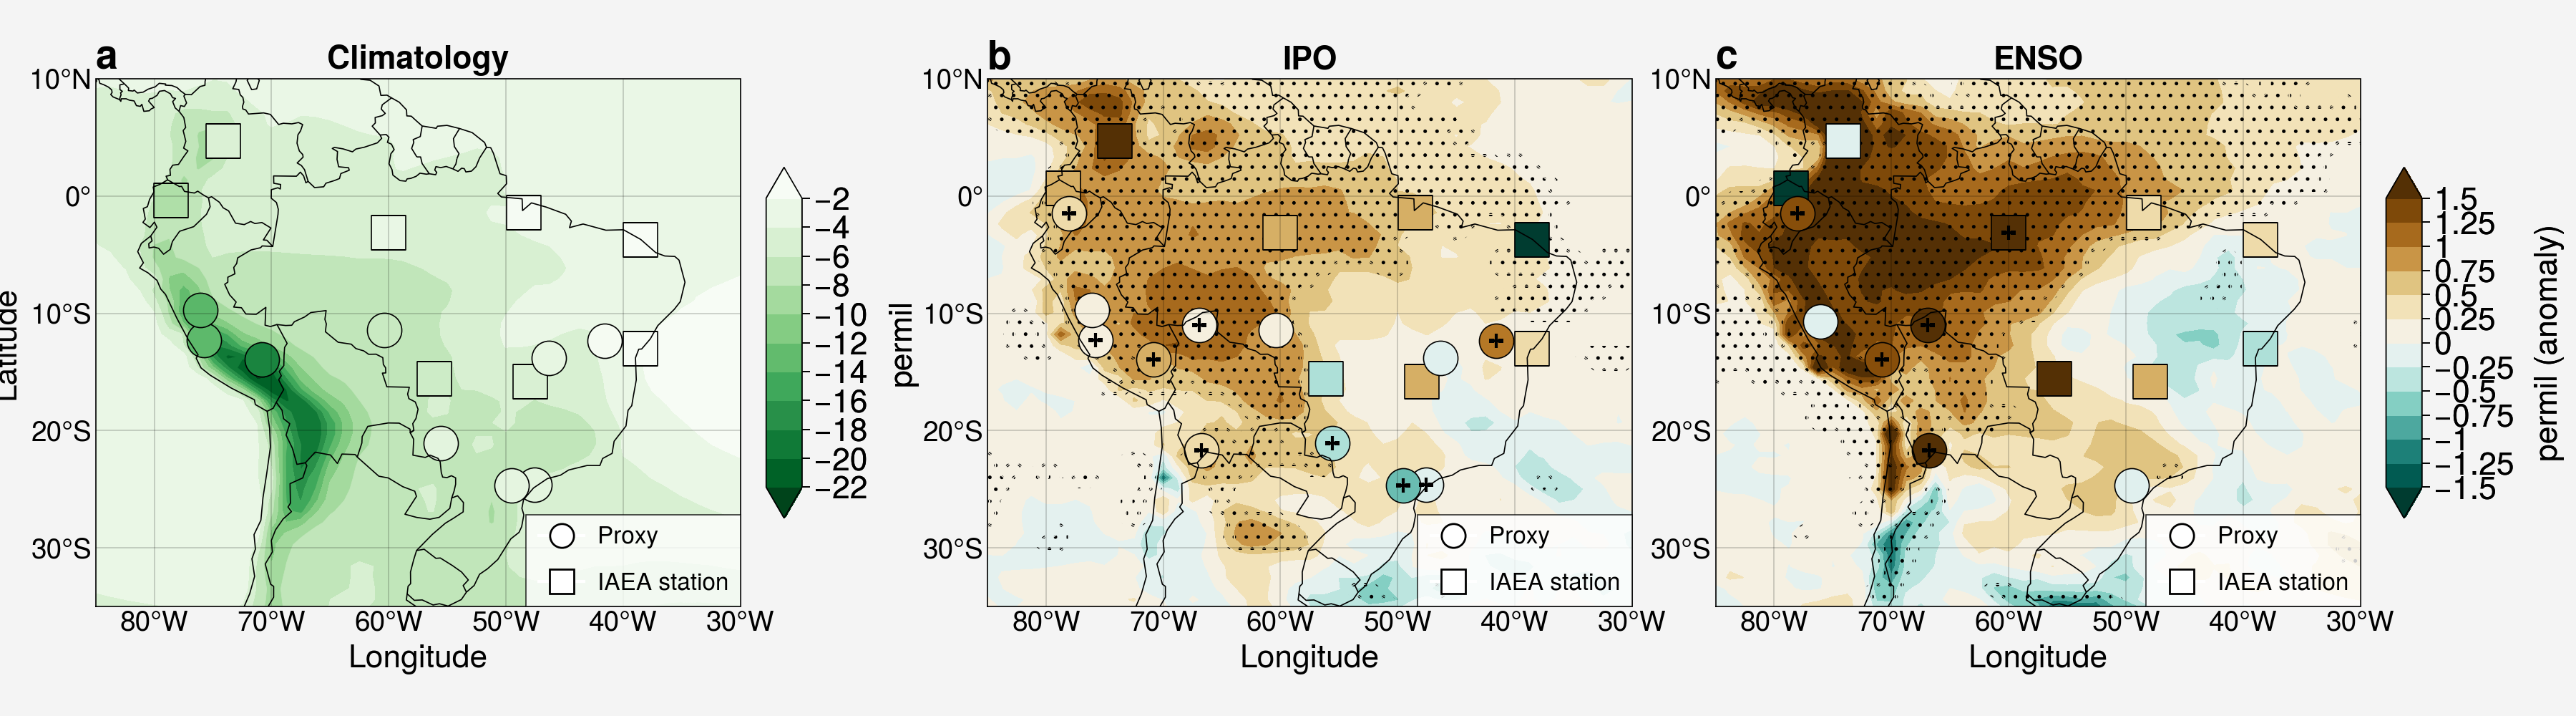

In [12]:
# global styling for plots
pplt.rc['abc.size'] = 20
# d18o, proxies
# climo, difference between cold and warm phases for ipo, enso
# 1880 -- 1999

# ---------------
# DJF
# ---------------
fig, axs = pplt.subplots(nrows=1, ncols=3, proj=('cyl'),figsize=(18, 5))
axs.format(
    land=False, labels=False, lonlines=10, latlines=10, abc='a', abcloc='l', coast = True, borders = True,
#     gridminor=True, suptitle='DJF composites, average, warm and cold pdo anomaly years based on 1.0 (1.5) std dev in mod (prox)'
) 
# axs.format(lonlim=(270,330), latlim=(-50,10), labels=True)
for ax in axs:
    ax.set_extent([330,275,10,-35], crs=ccrs.PlateCarree())
    ax.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
    ax.set_yticks([-30,-20,-10,0,10], crs=ccrs.PlateCarree())
    lon_fmt = LongitudeFormatter(number_format='.0f')
    lat_fmt = LatitudeFormatter(number_format='.0f')
    ax.yaxis.set_major_formatter(lat_fmt)
    ax.xaxis.set_major_formatter(lon_fmt)
    ax.set_xlabel('Longitude', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

axs[0].set_ylabel('Latitude', fontsize=16)
cmap = plt.get_cmap('brbg').reversed()
cmap2 = plt.get_cmap('greens').reversed()

## ----
## climo
## -----

djf_all = axs[0].contourf(lon, lat, d18_comp_icam, cmap=cmap2, vmin=-22.0, vmax=-2.0,
                   extend='both', transform=ccrs.PlateCarree())
axs[0].set_title('Climatology', fontsize=16, weight='bold')

# PLOT GNIP POINTS
for i in range(len(gnips_pw_ipo)):
    gnip_a = axs[0].scatter(grouped_pwpc_base[i]['lon'],grouped_pwpc_base[i]['lat'],c=grouped_pwpc_base[i]['d18o_pwt'], s=300,
                          cmap=cmap2, vmin=-22.0, vmax=-2.0, marker='s',
                          edgecolors='black', transform=ccrs.PlateCarree())

# PLOT PROXY POINTS; excluding tree rings (9'UTU', 10'Cuy', 11'Bol')
for i,r in enumerate(recs_ipo[:-3]):
    if i == 0: # 0'P00H1'
        prox = axs[0].scatter(lon_pts_ipo[i],lat_pts_ipo[i]-1,c=prox_comp[i], s=300,
                          cmap=cmap2, vmin=-22.0, vmax=-2.0,
                          edgecolors='black', transform=ccrs.PlateCarree())
    elif i == 8: # 8'Pumacocha',
        prox = axs[0].scatter(lon_pts_ipo[i],lat_pts_ipo[i]+1,c=prox_comp[i], s=300,
                          cmap=cmap2, vmin=-22.0, vmax=-2.0,
                          edgecolors='black', transform=ccrs.PlateCarree())
    elif i == 2: # 2'CR1'
        prox = axs[0].scatter(lon_pts_ipo[i]+1,lat_pts_ipo[i],c=prox_comp[i], s=300,
                          cmap=cmap2, vmin=-22.0, vmax=-2.0,
                          edgecolors='black', transform=ccrs.PlateCarree())
    else: # 1'JAR4', 3'SBE3', 4'DV2+TR5+LD12', 5'PIM4', 6'MFZ', 7'Quelccaya'
        prox = axs[0].scatter(lon_pts_ipo[i],lat_pts_ipo[i],c=prox_comp[i], s=300,
                          cmap=cmap2, vmin=-22.0, vmax=-2.0,
                          edgecolors='black', transform=ccrs.PlateCarree())

cbar = axs[0].colorbar(djf_all, label='permil',length=0.6,width = .25)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('permil',fontsize=16, labelpad = 10)

## ----
## IPO warm - cold years
## -----
levs=np.arange(-1.5,1.75,0.25)
djf_diff = axs[1].contourf(lon, lat, d18_pwc_icam_anom_ipo, cmap=cmap,  levels=levs,
                   extend='both', transform=ccrs.PlateCarree())
# axs[1].contourf(lon,lat,d18o_diff_mask, hatches=['.'],alpha=0.0)
axs[1].contourf(lon,lat,d18_diff_hatch_ipo, hatches=['..', ''],alpha=0.0)
axs[1].set_title('IPO', fontsize=16, weight='bold')

# -------------------------- GNIP
for i in range(len(gnips_pw_ipo)):
    if i == 6: # 6'Izobamba'
        if gnip_diff_sig_ipo[i][1] < 0.05:
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat']+1,c=gnips_pw_ipo[i]['d18o_pwt']-gnips_pc_ipo[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat']+1, s=50, marker='+', colors='black', 
                                         zorder=3, transform=ccrs.PlateCarree())
        else:
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat']+1,c=gnips_pw_ipo[i]['d18o_pwt']-gnips_pc_ipo[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
    else: # 0'Brazilia', 1'Cuiaba', 2'Salvador', 3'Fortaleza', 4'Manaus', 5'Belem', 7'Bogota'
        if gnip_diff_sig_ipo[i][1] < 0.05:
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat'],c=gnips_pw_ipo[i]['d18o_pwt']-gnips_pc_ipo[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat'], s=50, marker='+', colors='black', 
                                         zorder=3, transform=ccrs.PlateCarree())
        else:
            gnip_diff_a = axs[1].scatter(gnips_pw_ipo[i]['lon'],gnips_pw_ipo[i]['lat'],c=gnips_pw_ipo[i]['d18o_pwt']-gnips_pc_ipo[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())

# -------------------------- PROXIES
for i,r in enumerate(recs_ipo):
    if i == 0 or i == 10: # 0'P00H1', 10'Cuy' 
        if prox_diff_sig_ipo[r][1] < 0.05:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]-1,c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]-1, s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]-1,c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
    elif i == 8: # 8'Pumacocha'
        if prox_diff_sig_ipo[r][1] < 0.05:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]+1,c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]+1, s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i]+1,c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
    elif i == 2: # 2'CR1'
        if prox_diff_sig_ipo[r][1] < 0.05:
            prox_d = axs[1].scatter(lon_pts_ipo[i]+1,lat_pts_ipo[i],c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[1].scatter(lon_pts_ipo[i]+1,lat_pts_ipo[i], s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[1].scatter(lon_pts_ipo[i]+1,lat_pts_ipo[i],c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
    else:  # 1'JAR4', 3'SBE3', 4'DV2+TR5+LD12', 5'PIM4', 6'MFZ', 7'Quelccaya', 9'UTU', 11'Bol'
        if prox_diff_sig_ipo[r][1] < 0.05:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i],c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i], s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[1].scatter(lon_pts_ipo[i],lat_pts_ipo[i],c=prox_pwc_comp_anom_ipo[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
# axs[1].colorbar(djf_diff, label='permil (anomaly)')
        
## ----
## ENSO warm - cold years
## -----
levs=np.arange(-1.5,1.75,0.25)
djf_diff = axs[2].contourf(lon, lat, d18_pwc_icam_anom_enso, cmap=cmap,  levels=levs,
                   extend='both', transform=ccrs.PlateCarree())
# axs[1].contourf(lon,lat,d18o_diff_mask, hatches=['.'],alpha=0.0)
axs[2].contourf(lon,lat,d18_diff_hatch_enso, hatches=['..', ''],alpha=0.0)
axs[2].set_title('ENSO', fontsize=16, weight='bold')

# -------------------------- GNIP
for i in range(len(gnips_pw_enso)):
    if i == 6: # 6'Izobamba'
        if gnip_diff_sig_enso[i][1] < 0.05:
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat']+1,c=gnips_pw_enso[i]['d18o_pwt']-gnips_pc_enso[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat']+1, s=50, marker='+', colors='black', 
                                         zorder=3, transform=ccrs.PlateCarree())
        else:
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat']+1,c=gnips_pw_enso[i]['d18o_pwt']-gnips_pc_enso[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
    else: # 0'Brazilia', 1'Cuiaba', 2'Salvador', 3'Fortaleza', 4'Manaus', 5'Belem', 7'Bogota'
        if gnip_diff_sig_enso[i][1] < 0.05:
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat'],c=gnips_pw_enso[i]['d18o_pwt']-gnips_pc_enso[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat'], s=50, marker='+', colors='black', 
                                         zorder=3, transform=ccrs.PlateCarree())
        else:
            gnip_diff_a = axs[2].scatter(gnips_pw_enso[i]['lon'],gnips_pw_enso[i]['lat'],c=gnips_pw_enso[i]['d18o_pwt']-gnips_pc_enso[i]['d18o_pwt'], s=300,
                              cmap=cmap, levels=levs, marker='s', edgecolors='black', transform=ccrs.PlateCarree())

# -------------------------- PROXIES
for i,r in enumerate(recs_enso):
    if i == 4: # 4'Cuy'
        if prox_diff_sig_enso[r][1] < 0.05:
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i]-1,c=prox_pwc_comp_anom_enso[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i]-1, s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i]-1,c=prox_pwc_comp_anom_enso[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
    else: # 0'MFZ', 1'Quelccaya', 2'Pumacocha', 3'UTU', 5'Bol'
        if prox_diff_sig_enso[r][1] < 0.05:
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i],c=prox_pwc_comp_anom_enso[i], s=300,
                              cmap=cmap, levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i], s=50, marker='+', colors='black', 
                                    zorder=3,transform=ccrs.PlateCarree())
        else:
            prox_d = axs[2].scatter(lon_pts_enso[i],lat_pts_enso[i],c=prox_pwc_comp_anom_enso[i], s=300,
                              cmap=cmap,levels=levs,
                              edgecolors='black', transform=ccrs.PlateCarree())

legend_elements = [Line2D([0], [0], color = 'w', markeredgecolor = 'k', markeredgewidth = 1, marker='o', label='Proxy', markersize=12),
                   Line2D([0], [0], color = 'w', markeredgecolor = 'k', markeredgewidth = 1, marker = 's', label='IAEA station',  markersize=12)]

#PLOT LEGEND
for ax in axs:
    ax.legend(legend_elements,loc='lr',ncols=1, fontsize=18,labelspacing=1.0)#center=True, frameon=True)

cbar = axs[2].colorbar(djf_diff, length=0.6,width = .25)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('permil (anomaly)',fontsize=16, labelpad = 10)
# plt.savefig('/network/rit/home/ro553136/orrison/Plots/Pac_SAm/ipo_enso_composites/Fig3_d18opwt_mod_prox_gnip_ipo_enso_1880_1999_diff.jpg', format='JPEG',dpi=300)
pplt.rc.reset()